In [1]:
import torch
import numpy as np
from numpy.linalg import norm
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import math
# for Compute RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

/anaconda3/lib/python3.6/site-packages/scipy/__init__.py:144: UserWarning: Numpy 1.13.3 or above is required for this version of scipy (detected version 1.13.1)
  UserWarning)


In [2]:
def get_repeated_Indices(list_of_indices):
    #input: string of indices for the tensors. 
    #output: string of repeated indices. code takes in indices and output only the repeated indices
    #Ex: Suppose tensor A has index ijkp, and tensor B has index klpm.
    #then get_repeated_Indices('ijkp', 'klpm') will return the following string: 'kp'
    myList = list_of_indices
    #convert List to string
    myString =''.join(myList)
    #break the string into indivual list of characters ex.  'abc' ->['a','b', 'c']
    myList = list(myString)
    #get the repeated frequencies of each indices
    my_dict = {i:myList.count(i) for i in myList}
    
    repeatedList = []
    for item in my_dict:
        if my_dict[item] > 1:
            repeatedList.append(item)
    return repeatedList

def  remove_Repeated_indices(List_of_indices):
    #inputs: tensor indices in the form of string
    #output: string of non repeated indicies
    #Ex: remove_Repeated_indices('abc', 'cde')
    #output of the example would be: 'abde'
    
    myList = List_of_indices 
    #turn myList into String: Ex: ['abc','cde'] -> 'abccde'
    myString = ''.join(myList)
    #turn back into lists again: Exp: from 'abccde' -> ['a','b','c','c','d','e']
    myList = list(myString)
    repeated_indices = get_repeated_Indices(List_of_indices)
    #print('the repeated list of indices are:', repeated_indices)
    unique_indices = []
    #now we remove repeated indices from myList
    for item in myList:
        if item not in repeated_indices:
            unique_indices.append(item)
    uniqueString = ''.join(unique_indices)   
    return uniqueString

def einSum_Contraction(tensorList, indxList):  #<----should rename this to einSum_Contraction to replace old code
    #Purpose: this function takes a list of tensors, and list of indices, and indix to contract and uses einstien summation to perform contraction
    #ex: tensorList = [tensor1, tensor2, tensor3]
    #indxList   = [indx1, indx2, indx3]
    myList = []
    uniqueIndices = remove_Repeated_indices(indxList)
    inputIndices = [indxList]
    N = len(indxList)
    #myList = [indx1, ',',indx2,',',indx3,'->', uniqueIndices] 
    for i in range(N - 1):
        myList.append(indxList[i])
        myList.append(',') 
    myList.append(indxList[N-1])
    myList.append('->')
    myList.append(uniqueIndices)
    #convert myList to a string: i.e.  [indx1, ',',indx2,',',indx3,'->', uniqueIndices]  - >'ijk,klm,mjp->ilp'
    myString = ''.join(myList)
    #print('myString = ', myString)
    C = torch.einsum(myString, tensorList)
    return C

In [3]:
def padTensor(tensor, pad_axis):
    #this is for the discrete optimization
    #this function takes a tensor and append an extra dimension of ~ zeros along the specified axis (we call the pad axis)
    if pad_axis == -1:
        return tensor #don't pad anything
    tensorShape = list(tensor.shape)
    tensorShape[pad_axis] = 1  #increase the dimension up by 1
    zerosPad = torch.rand(tensorShape) *1e-6  #pad with values approx. equal to zero
    padded_tensor = torch.cat([tensor, zerosPad], pad_axis)
    #print('padded_tensor.shape = ', padded_tensor.shape)
    #print('padded_tensor function output = ', padded_tensor)
    return padded_tensor

In [4]:
def increaseRank(Tensor1, Tensor2, indx1, indx2):
    # The indx 1 and index2 represents the indices for tensor 1 and 2 respectively. 
    #There is only one repeated index in the list (indx1, indx2). The repeated index represents the shared edge between
    #the two tensors. For ex: ijkl, lmno
    alpha = get_repeated_Indices([indx1, indx2])
    if len(alpha) != 0 :
        #convert alpha to string
        alpha = ''.join(alpha)
        # find the position of the repeated index alpha in indx1 and indx2
        padAxes1 = indx1.index(alpha)
        padAxes2 = indx2.index(alpha)  
        Tensor1 = padTensor(Tensor1, padAxes1)
        Tensor2 = padTensor(Tensor2, padAxes2)
    return  Tensor1, Tensor2

In [5]:
def Tensor_Generator(TensorDimension):
#input: desired target tensor dimension in the form of a list. Ex: input d1xd2xd3 as [d1, d2, d3]
#output: target tensor with random entries drawn from a normal distribution of mean=0 and variance=1
    Tensor = torch.randn(TensorDimension)
    return Tensor

In [6]:
def getOneData_point(W):
# W is input tensor
#X are drawn from a normal distribution of mean=0 and variance=1 
#output: Xi, yi  = targetTensor * X
    indxList = []
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    Xi = Tensor_Generator(W.shape) #generate Tensor Xi with same shape as input tensor W
    for j in range(len(Xi.shape)):
        indxList.append(alphabet[j])
        indx = ''.join(indxList)
    tensorList = [W, Xi]
    #W and X have same index so that yi is a scaler
    yi = einSum_Contraction([W,Xi], [indx, indx])
    return Xi, yi, indx  #W and Xi shares the same indx

def data_Set_Generator(tensor, N):
    #N = number of training data you want
    #tensor is usually the target tensor 
    Xi_set = []
    yi_set = []
    for i in range(N):
        Xi, yi, indx = getOneData_point(tensor)
        Xi_set.append(Xi)
        yi_set.append(yi)
    return Xi_set, yi_set,indx  #tensor and Xi shares the same indx

def getYi_set(Xi_set, tensor, indxList):
    #this function generates a N number of yi's using yi = tensor*Xi_set[i]. 
    #The input tensor is usually either the approx. tensor or the target tensor.
    #indxList = [indx_Xi, indx_tensor]
    yi_set = []
    N = len(Xi_set)      #is there are N elements of Xi in Xi_set, there will be N elements of yi in yi_set
    for i in range(N):
        yi = einSum_Contraction([tensor,Xi_set[i]], indxList)
        yi_set.append(yi)
    return yi_set

def innerProduct_Tensor(T,A):
    #input: inner product of two tensors T and A of same dimension equals the sum of the product of their entries 
    #covert T, and A tensors in to 1 D tensors
    T = T.view(1,-1)   #convert tensor  to 1D
    T = T.squeeze()    #squeeze out any extra dimension
    A = A.view(1,-1)
    A = A.squeeze()
    #perform inner product of two 1D tensors
    yi = sum(torch.mul(T,A))
    return yi

def printRank(TensorList):
    [r5,r6,r7,r8] = (TensorList[4].shape) #tensor G dimension
    [r4,d4,r3,r5] = (TensorList[3].shape) #tensor D dimension
    [r2,d1,r1,r7] = (TensorList[0].shape) #tensor A dimension
    r = [r1,r2,r3,r4,r5,r6,r7,r8]
    return r

def getNumParams(r):
    #r = list of ranks of a tensor
    numParam = d1*r[0]*r[6]*r[1] + d2*r[0]*r[7]*r[3]+ d3*r[1]*r[5]*r[2] + d4*r[3]*r[4]*r[2] + r[4]*r[5]*r[6]*r[7]
    return numParam

def getNumParams_stoch(r):
    #r = [r0,r1,r2,r3,...,r7] 
    #we want to compuate the dimension of the block we start with. For exmape
    #we started with 4 order tensor, which can be approximated by 5 tensors
    #below computes the number of params for each of the tensor
    numParam1 = d1*r[0]*r[6]*r[1]
    numParam2 = d2*r[0]*r[7]*r[3]
    numParam3 = d3*r[1]*r[5]*r[2]
    numParam4 = d4*r[3]*r[4]*r[2]
    numParamCore = r[4]*r[5]*r[6]*r[7] 
    numParamList = [numParam1, numParam2, numParam3, numParam4, numParamCore]
    return numParamList

def computeLoss_Regression(yi_set, Xi_set, approxTensor):
    #N is total number of training/test data
    sum = 0
    N = len(yi_set)
    for i in range(N):
        # y_approx = innerProduct(ApproxTensor, X_i)
        y_approx = innerProduct_Tensor(approxTensor, Xi_set[i])
        loss = (yi_set[i] - y_approx)**2
        sum = sum + loss
    #divide by N to average the squared error of the cost function  so that the cost function doesn't depend on the number 
    #of elements in the training set.
    total_loss = 1/(2*N)*sum 
    return(total_loss)

def get_RandomSeqence(seqLength,d):
    #input: seqLength = len(r)  where r = [r0()),...r(n)]
    #input d: maxvalue a rank can take be set to i.e 1=<r<=d
    #return: a list of random ranks with each element ranging beween 1=<r<=d
    r = []
    for i in range(seqLength):
        r.append(random.randint(1,d))
    return 

def increaseRank(Tensor1, Tensor2, indx1, indx2):
    # The indx 1 and index2 represents the indices for tensor 1 and 2 respectively. 
    #There is only one repeated index in the list (indx1, indx2). The repeated index represents the shared edge between
    #the two tensors. For ex: ijkl, lmno
    alpha = get_repeated_Indices([indx1, indx2])
    if len(alpha) != 0 :
        #convert alpha to string
        alpha = ''.join(alpha)
        # find the position of the repeated index alpha in indx1 and indx2
        padAxes1 = indx1.index(alpha)
        padAxes2 = indx2.index(alpha)  
        Tensor1 = padTensor(Tensor1, padAxes1)
        Tensor2 = padTensor(Tensor2, padAxes2)
    return  Tensor1, Tensor2

def getNextDirection(r_list):
    #this function is for random walk
    #input: r_list = [r0,r1,...r7] 
    #output: nextDirection is a scaler that index the position of rank chosen
    nextDirection = random.randint(0, len(r_list)-1)
    print('nextDirection = ', nextDirection)
    return nextDirection

def get_Next_randomEdge(nextDirection1, r_list):   
    #this function is for random walk
    #input: r_list = [r0,r1,...r7] 
    #       nextDirection = scaler. 
    #output: chosen random edge
    nextDirection1 = random.randint(0, len(r_list)-1)
    #print('nextDirection = ', nextDirection)
    r_list[nextDirection1] = 1 + r_list[nextDirection1]
    return r_list


def get_indexString(chosenEdge, indxList):
     #this function is for random walk
    #goal: returns all the index strings that contains the input letter
    #input: chosenEdge = an alphebtical letter. Ex: l
    #       indexList1: list of strings of indices. Ex:indxList1 = [kilc', 'ljed', 'eabc']
    #output: indexStringList: elements in list containing chosenEdge. Ex: if choseEdge = 1, then code will return IndexStringList = [kilc', 'ljed'] 
           # indx: positon in the list containing the chosenEdge.
    indexStringList = []
    indx = []
    position = 0
    for indexString in indxList:
        if chosenEdge in indexString:
            indexStringList.append(indexString)
            indx.append(position)  
           # print('position = ', position, 'indexString = ', indexString)
        position = position + 1
    return indexStringList, indx

def solve_Continuous(target_Tensor, tensorList, indxList, iterNum):
#input: list of tensors and their corresponding indices
#Goal: The purpose of this function is to solve the innerloop of the optimization for the problem
    len_Tensor = len(tensorList)
    len_Indx   = len(indxList)
    for i in range(len_Tensor):
        tensorList[i] = tensorList[i].detach()
        tensorList[i].requires_grad = True
    #defines a SGD optimizer to update the parameters
    #optimizer = optim.SGD(tensorList lr = 0.001, momentum=0.2)
    optimizer = optim.Adam(tensorList, lr=0.009)
    #initialize parameters      
    LostList = []              #use this to plot the lost function
    for i in range(iterNum):
        optimizer.zero_grad()
        tensor_approx = einSum_Contraction(tensorList, indxList)
        #loss_fn = computeLoss(tensor_approx, target_Tensor)   # this is for tensor decomp: ||W_target - W_approx||_Fˆ2
        loss_fn =computeLoss_Regression(yi_train, Xi_train, tensor_approx)
        loss_fn.backward()
        optimizer.step()                # the new A,B,C will be A_k+1,B_k+1, C_k+1 after optimizer.step 
        LostList.append(float(loss_fn))
    return tensorList, indxList, LostList

def greedyMethod(indxList, maxParam, numOuter_iterations, TensorList, TensorList_temp):
    #maxParam = number of parameters in target tensor
    #list of indices for the initial block tensors
    
    #Initialize data
    iterNum=20   #500
    Lost_star = 1e12  #set it to be any large number
    check = 1
    numParam = -1
    paramKey = -1
    greedy_loss_List = []  # list of Lostlist[-1]
    RMSE_greedy_list = []
    
    for k in range(numOuter_iterations):   #discrete optimizaton loop
        if paramKey == 1:
            break
        for i in range(len(TensorList_temp)):
            if paramKey == 1:
                break
            for j in range(i,len(TensorList_temp)):
                if paramKey == 1:
                    break
                if i==j:
                    continue
            #print(i,j)
            #check num of paramters for the newly updated ranks
           # rt = list of ranks: [r1_t,r2_t,r3_t,r4_t,r5_t,r6_t,r7_t,r8_t]
                rt = printRank(TensorList_temp)
                numParam_temp = getNumParams(rt)
                print('numParam_greedy=', numParam_temp)
                if numParam_temp > maxParam:
                    paramKey = 1
                    print('Max number of parameters exceeded. Current Param = ', numParam_temp, 'and max Param allowed = ', maxParam)
                    print('program finish ')
                    break
                #solve continuous part
                [TensorList_temp, indxList, LostList] = solve_Continuous(target_Tensor, TensorList_temp, indxList, iterNum)
                printRank(TensorList_temp)
                #store the optimal value for a given point around its neighbour
                if Lost_star > LostList[-1]: 
                        indx_star = [i,j]
                        TensorList_star = TensorList_temp[:]
                        indxList_star = indxList[:]  
                        Lost_star = LostList[-1]  
                        r_greedy = printRank(TensorList_star)
                        print('r_greedy = ', r_greedy)
                        numParam = getNumParams(r_greedy )
                        check = -1
                elif Lost_star <= LostList[-1]:
                    print('k = ', k, 'Lowest Loss found so far = ', Lost_star, 'Current Loss = ', LostList[-1])
                    print('Loss previous is less than current, so no rank update is made at this iteration')
                    print('total number of parameters for best chosen rank = ', numParam)
         
                #Reset TensorList_temp to continue with greedy at another point
                TensorList_temp = TensorList[:] #set back to previous position to continue with greedy search arounnd the point       
                #increase the ranks of the tensors
                [TensorList_temp[i],TensorList_temp[j]] = increaseRank(TensorList_temp[i], TensorList_temp[j],  indxList[i], indxList[j])            
        #update parameters   
        TensorList_temp = TensorList_star[:]    #everything is behaving as expected
        indxList = indxList_star[:]     # don't really need to update this cause these don't really change
        TensorList_greedy   = TensorList_star[:]  #everything is behaving as expected
        greedy_loss_List.append(Lost_star)
    #TensorList contains decomposed block of tensors. We use einsum to combine them into one 
    #big tensor Tapprox_greedy
    Tapprox_greedy = einSum_Contraction(TensorList_greedy, indxList)  #TensorList_Greedy = TensorList
    print('Tapprox_greedy.shape = ', Tapprox_greedy.shape)

    #generate yi_approx = tensorApprox_star * X_i. Plot this set of yi_approx, with yi
    indxlist_greedy = ['abcd', 'abcd']   # abcd =  = d1*d2*d3*d4 i.e. each alphabet represents each dimension ot target tensor
    yi_approxSet_greedy = getYi_set(Xi_test, Tapprox_greedy, indxlist_greedy)
    print('len(yi_approxSet_greedy) = ', len(yi_approxSet_greedy))
    return yi_approxSet_greedy, greedy_loss_List

#***********************RANDOM WALK*****************************************
def randomWalk(TensorList_RW, maxParam, Xi_set):
#input: maxParam = number of parameters in target tensor
# Xi_set: could be the traing set or test set 
    #initialize the edges to 1
    r_RW = [1,1,1,1,1,1,1,1]   #rank list for random walk
    rankList_indx = ['l', 'k', 'g', 'e', 'a', 'b', 'c', 'd']
    iterNum = 20 #100          #number of iterations for continuous optimization
    numParam_RW = getNumParams(r_RW)
    indxListRW = indxList1     #indxList1 is a global variable
    RW_lost_list = []
    TensorList_RW = TensorList1[:] # TensorList1  = [A_0,B_0,C_0,D_0,G_0] 
    RMSE_RW = []
    while maxParam > numParam_RW:
        numParam_RW = getNumParams(r_RW)
        #initialize tensor 
        if maxParam > numParam_RW:
            #recall target_tensor and is a global variable
            [TensorList_RW, indxListRW, LostList_RW] = solve_Continuous(target_Tensor, TensorList_RW, indxListRW, iterNum)
            RW_lost_list.append(LostList_RW[-1])  
            nextDirection = getNextDirection(r_RW) 
            chosenEdge = rankList_indx[nextDirection]
            r_RW = get_Next_randomEdge(nextDirection, r_RW)
            print('next direction =', nextDirection,'r_RW = ', r_RW)
            rankString, Tensor_indexRW = get_indexString(chosenEdge, indxList1)  #rankString is a list. Ex. ['abc','kbg']
            #increaseRank and padded new dimensions with approx. 0
            [TensorList_RW[Tensor_indexRW[0]], TensorList_RW[Tensor_indexRW[1]]] = increaseRank(TensorList_RW[Tensor_indexRW[0]], TensorList_RW[Tensor_indexRW[1]], rankString[0], rankString[1])      
            print('Random Walk: numParam = ', numParam_RW, 'maxNumParam of target tensor = ', maxParam)
        else:
            print('')
            print('program finished! cant perform another loop else will get numParameters > maxParam')

    #take the block tensors and combine them to form 1 big tensor: TensorApprox_RW 
    # indxList1 = [indxA, indxB, indxC, indxD, indxG]. We use the exact same indxList as the ones above
    TensorApprox_RW = einSum_Contraction([TensorList_RW[0], TensorList_RW[1], TensorList_RW[2], TensorList_RW[3], TensorList_RW[4]], indxList1)
    indxlist_RW = ['abcd', 'abcd']   # abcd =  = d1*d2*d3*d4 i.e. each alphabet represents each dimension ot target tensor
    yi_approxSet_RW = getYi_set(Xi_set, TensorApprox_RW, indxlist_RW)
    
    return yi_approxSet_RW 


In [7]:
                                         ######***Eperiment****** ######
#generate 4-order target tensor
#see ipad for supplementary notes on this tensor and its diagram

#Start with 5 nodes (not 4 cause we are including a core node)
d1 = 3
d2 = 3
d3 = 3
d4 = 3
d5 = 3
r0 = 2
r1 = 3
r2 = 4
r3 = 3
r4 = 2
r5 = 3
r6 = 2
r7 = 2

noise = 1e-6
#generate at random target tensor

A = torch.rand(r1,d1,r0,r6) # + torch.rand(r1,d1,r0,r6)*noise
B = torch.rand(r0,d2,r3,r7) # + torch.rand(r0,d2,r3,r7)*noise
C = torch.rand(r1,d3,r2,r5) # + torch.rand(r1,d3,r2,r5)*noise
D = torch.rand(r3,d4,r2,r4) # + torch.rand(r3,d4,r2,r4)*noise 
G = torch.rand(r4,r5,r6,r7) # + torch.rand(r4,r5,r6,r7)*noise   #core node

indxA = 'kilc'
indxB = 'ljed'
indxC = 'khgb'
indxD = 'efga'
indxG = 'abcd'   #core tensor

indxList1 = [indxA, indxB, indxC, indxD, indxG]
target_Tensor = einSum_Contraction([A,B,C,D,G], [indxA, indxB, indxC, indxD, indxG])

In [8]:
#generate training and test sets
N=20
#p is the percentage of the total number of data N
p = int(np.floor(0.65*20))  #so is is 65% of the original data
[Xi_data, yi_data, indx] = data_Set_Generator(target_Tensor, N) 
Xi_train = Xi_data[0:p]
yi_train  = yi_data[0:p]
Xi_test = Xi_data[p:N+1]
yi_test = yi_data[p:N+1]

In [9]:
            ##main script for plotting RMSE vs outer loop for greedy and Random walk############

numOuter_iter1 = [1]  #[2,3,4,5]
RMSE_greedyList = []
RMSE_RW_List = []
RMSE_Stoch_List = []

r0 = 1
r1 = 1
r2 = 1
r3 = 1
r4 = 1
r5 = 1
r6 = 1
r7 = 1
maxParam1 = d1*d2*d3*d4
print('maxParam allowed = ', maxParam1)

#Greedy approach: initialize parameters
#noise =  1e-6
A_0 = torch.rand(r1,d1,r0,r6)   # + torch.rand(r1,d1,r0,r6)*noise
B_0 = torch.rand(r0,d2,r3,r7)   # + torch.rand(r0,d2,r3,r7)*noise
C_0 = torch.rand(r1,d3,r2,r5)   # + torch.rand(r1,d3,r2,r5)*noise
D_0 = torch.rand(r3,d4,r2,r4)   # + torch.rand(r3,d4,r2,r4)*noise
G_0 = torch.rand(r4,r5,r6,r7)   # + torch.rand(r4,r5,r6,r7)*noise
TensorList1 = [A_0,B_0,C_0,D_0,G_0] 
TensorList_temp1 = [A_0,B_0,C_0,D_0,G_0] #TensorList[:]

#RandomWalk
yi_approxSet_RW = randomWalk(TensorList1, maxParam1, Xi_test)

#stochastic
iterNum1=100   #500
max_numShot1 = 50 
maxRank1=5  # 1<=r(i)<=maxR

#RMSE for Random walk
yi_approxSet_RW = randomWalk(TensorList1, maxParam1,  Xi_test)
RMSE_RW = sqrt(mean_squared_error(yi_test,yi_approxSet_RW))   #single point

#RMSE for greedy
#num_Outer_loop = [2,3,4]
for t in range(1,len(yi_approxSet_RW)+1):   #len(RMSE_RW_List) = number of outer iterations for greedy i.e. number of  discrete optimizationloop
    print('t = ', t, 'RMSE_RW = ', len(RMSE_RW_List))
    yi_approxSet_greedy, greedy_loss_List = greedyMethod(indxList1, maxParam1, t, TensorList1, TensorList_temp1)
    RMSE_greedy = sqrt(mean_squared_error(yi_test,yi_approxSet_greedy))
    RMSE_greedyList.append(RMSE_greedy)
    


maxParam allowed =  81
nextDirection =  2
next direction = 2 r_RW =  [1, 1, 2, 1, 1, 1, 1, 1]
Random Walk: numParam =  13 maxNumParam of target tensor =  81
nextDirection =  6
next direction = 6 r_RW =  [1, 1, 2, 1, 2, 1, 1, 1]
Random Walk: numParam =  19 maxNumParam of target tensor =  81
nextDirection =  1
next direction = 1 r_RW =  [1, 1, 2, 1, 2, 2, 1, 1]
Random Walk: numParam =  26 maxNumParam of target tensor =  81
nextDirection =  6
next direction = 6 r_RW =  [1, 1, 3, 1, 2, 2, 1, 1]
Random Walk: numParam =  34 maxNumParam of target tensor =  81
nextDirection =  6
next direction = 6 r_RW =  [2, 1, 3, 1, 2, 2, 1, 1]
Random Walk: numParam =  46 maxNumParam of target tensor =  81
nextDirection =  4
next direction = 4 r_RW =  [3, 1, 3, 1, 2, 2, 1, 1]
Random Walk: numParam =  52 maxNumParam of target tensor =  81
nextDirection =  4
next direction = 4 r_RW =  [3, 1, 3, 1, 2, 2, 2, 1]
Random Walk: numParam =  58 maxNumParam of target tensor =  81
nextDirection =  7
next direction = 7 r

r_greedy =  [1, 1, 2, 1, 1, 1, 1, 1]
numParam_greedy= 17
k =  0 Lowest Loss found so far =  64.3000717163086 Current Loss =  82.16265869140625
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  19
numParam_greedy= 19
r_greedy =  [1, 1, 2, 1, 1, 1, 1, 1]
numParam_greedy= 19
k =  1 Lowest Loss found so far =  32.73167037963867 Current Loss =  77.39057159423828
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  19
numParam_greedy= 19
k =  1 Lowest Loss found so far =  32.73167037963867 Current Loss =  66.28870391845703
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  19
numParam_greedy= 13
k =  1 Lowest Loss found so far =  32.73167037963867 Current Loss =  79.47013092041016
Loss previous is less than current, so no rank update is made at this iterati

k =  1 Lowest Loss found so far =  24.77899169921875 Current Loss =  79.97479248046875
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  19
numParam_greedy= 19
r_greedy =  [1, 1, 2, 1, 1, 1, 1, 1]
numParam_greedy= 19
k =  2 Lowest Loss found so far =  5.7055840492248535 Current Loss =  73.66370391845703
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  19
numParam_greedy= 19
k =  2 Lowest Loss found so far =  5.7055840492248535 Current Loss =  72.2882308959961
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  19
numParam_greedy= 13
k =  2 Lowest Loss found so far =  5.7055840492248535 Current Loss =  80.15557098388672
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  

k =  1 Lowest Loss found so far =  34.991119384765625 Current Loss =  81.04820251464844
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  19
numParam_greedy= 17
k =  1 Lowest Loss found so far =  34.991119384765625 Current Loss =  80.99176025390625
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  19
numParam_greedy= 19
r_greedy =  [1, 1, 2, 1, 1, 1, 1, 1]
numParam_greedy= 19
k =  2 Lowest Loss found so far =  14.931836128234863 Current Loss =  73.15251922607422
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  19
numParam_greedy= 19
k =  2 Lowest Loss found so far =  14.931836128234863 Current Loss =  74.74822998046875
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =

k =  0 Lowest Loss found so far =  67.28438568115234 Current Loss =  78.65245819091797
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  19
numParam_greedy= 19
k =  0 Lowest Loss found so far =  67.28438568115234 Current Loss =  77.78730773925781
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  19
numParam_greedy= 17
k =  0 Lowest Loss found so far =  67.28438568115234 Current Loss =  83.62897491455078
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  19
numParam_greedy= 19
k =  0 Lowest Loss found so far =  67.28438568115234 Current Loss =  75.76081848144531
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  19
numParam_greedy= 17
k =  0 Lowest Loss found so far =  6

k =  4 Lowest Loss found so far =  17.219196319580078 Current Loss =  82.95533752441406
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  19
numParam_greedy= 17
k =  4 Lowest Loss found so far =  17.219196319580078 Current Loss =  82.57357025146484
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  19
numParam_greedy= 13
k =  4 Lowest Loss found so far =  17.219196319580078 Current Loss =  78.0239028930664
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  19
numParam_greedy= 19
k =  4 Lowest Loss found so far =  17.219196319580078 Current Loss =  74.86674499511719
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  19
numParam_greedy= 17
k =  4 Lowest Loss found so far =

k =  2 Lowest Loss found so far =  15.886763572692871 Current Loss =  79.59817504882812
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  19
numParam_greedy= 17
k =  2 Lowest Loss found so far =  15.886763572692871 Current Loss =  78.25191497802734
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  19
numParam_greedy= 13
k =  2 Lowest Loss found so far =  15.886763572692871 Current Loss =  82.82535552978516
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  19
numParam_greedy= 19
k =  2 Lowest Loss found so far =  15.886763572692871 Current Loss =  79.27071380615234
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  19
numParam_greedy= 17
k =  2 Lowest Loss found so far 

k =  5 Lowest Loss found so far =  6.120943069458008 Current Loss =  82.3183822631836
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  19
numParam_greedy= 19
k =  6 Lowest Loss found so far =  6.120943069458008 Current Loss =  7.273891925811768
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  19
numParam_greedy= 19
k =  6 Lowest Loss found so far =  6.120943069458008 Current Loss =  72.6371841430664
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  19
numParam_greedy= 19
k =  6 Lowest Loss found so far =  6.120943069458008 Current Loss =  71.18704223632812
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  19
numParam_greedy= 13
k =  6 Lowest Loss found so far =  6.1

In [10]:
yi_approxSet_RW = randomWalk(TensorList1, maxParam1,  Xi_test)
RMSE_RW = sqrt(mean_squared_error(yi_test,yi_approxSet_RW))   #single point

nextDirection =  1
next direction = 1 r_RW =  [1, 2, 1, 1, 1, 1, 1, 1]
Random Walk: numParam =  13 maxNumParam of target tensor =  81
nextDirection =  1
next direction = 1 r_RW =  [1, 2, 1, 1, 1, 1, 2, 1]
Random Walk: numParam =  19 maxNumParam of target tensor =  81
nextDirection =  7
next direction = 7 r_RW =  [1, 2, 1, 1, 1, 1, 3, 1]
Random Walk: numParam =  26 maxNumParam of target tensor =  81
nextDirection =  3
next direction = 3 r_RW =  [1, 2, 1, 2, 1, 1, 3, 1]
Random Walk: numParam =  33 maxNumParam of target tensor =  81
nextDirection =  7
next direction = 7 r_RW =  [1, 3, 1, 2, 1, 1, 3, 1]
Random Walk: numParam =  39 maxNumParam of target tensor =  81
nextDirection =  3
next direction = 3 r_RW =  [1, 4, 1, 2, 1, 1, 3, 1]
Random Walk: numParam =  51 maxNumParam of target tensor =  81
nextDirection =  4
next direction = 4 r_RW =  [1, 4, 1, 3, 1, 1, 3, 1]
Random Walk: numParam =  63 maxNumParam of target tensor =  81
nextDirection =  3
next direction = 3 r_RW =  [2, 4, 1, 3, 1, 

In [14]:
print(greedy_loss_List)

[65.80760192871094, 31.6014461517334, 15.886763572692871, 13.361574172973633, 6.120943069458008, 6.120943069458008, 6.120943069458008]


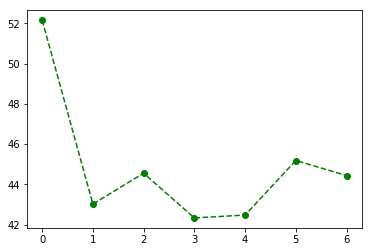

In [15]:
##PLOT FOR RANDOM WALK. X-AXIS = total number of steps and Y-axis = LostList[-1]
import matplotlib.pyplot as plt
plt.figure()
plt.plot(RMSE_greedyList, 'og--')
plt.show()